---
# ***SETTINGS***
---

In [1]:
# SARA: montiamo a drive per collegarci alla cartella desiderata
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# SARA: ecco la cartella desiderata
%cd /content/gdrive/MyDrive/ProgettoManoRobotica-AEA

/content/gdrive/MyDrive/ProgettoManoRobotica-AEA


In [53]:
# SARA: import delle librerie utili
import numpy as np # <-- libreria per calcoli base
from numpy import cov
import seaborn as sns
import matplotlib.pyplot as plt # <-- libreria per plottare le cose
import json # <-- libreria per formato dei file .json
from scipy import stats # <-- libreria per studi di correlazione
from scipy.stats import pearsonr
from scipy.stats import kendalltau
import pandas as pd
from scipy.stats import spearmanr
import json
from scipy.interpolate import interp1d, RBFInterpolator, Rbf, interpn, RegularGridInterpolator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50

# IMPORT LIBRARIES
import json
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import math
from re import X
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D, Multiply, Reshape, Dense
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers

import random
import numpy as np
seed = 4

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

---
# ***SOLVING THE MISMATCH***
---

In [6]:
# I CREATE A LIST OF SINGLE DATAFRAMES AND THEN I CONCATENATE ALL OF THEM FOR MY FUTURE CLASSIFICATION TASK
dfs_list = []
lenght =  []
phases = []

# Iterate through all the JSON files in the specified range
for i in range(21, 22):
    # Generate the file name (assuming the format is POWxxx.json)
    json_file_name = f'POW{i:03d}.json'
    json_file_path = os.path.join('/content/gdrive/MyDrive/SAPIENS/DB_Macchinine', json_file_name)

    # Check if the file exists before attempting to read it
    if os.path.exists(json_file_path):
        with open(json_file_path, 'r') as json_file:
            data = json.load(json_file)

        rows = []
        # Iterate through the JSON data
        for key, value in data.items():
            user_id = value['UserID']
            readings = value['Readings']

            for reading_key, reading_value in readings.items():
                phase = reading_value['Phase']
                if phase not in phases:
                  phases.append(phase)
                if phase in  ["sudoku", "Sudoku", "Baseline 000", "baseline 001", "Baseline 002", "Baseline 003"]:
                    time = reading_value['Time']
                    af3_theta = reading_value['AF3']['Theta']
                    af3_alpha = reading_value['AF3']['Alpha']
                    af3_betaL = reading_value['AF3']['BetaL']
                    af3_betaH = reading_value['AF3']['BetaH']
                    af3_gamma = reading_value['AF3']['Gamma']

                    t7_theta = reading_value['T7']['Theta']
                    t7_alpha = reading_value['T7']['Alpha']
                    t7_betaL = reading_value['T7']['BetaL']
                    t7_betaH = reading_value['T7']['BetaH']
                    t7_gamma = reading_value['T7']['Gamma']

                    pz_theta = reading_value['Pz']['Theta']
                    pz_alpha = reading_value['Pz']['Alpha']
                    pz_betaL = reading_value['Pz']['BetaL']
                    pz_betaH = reading_value['Pz']['BetaH']
                    pz_gamma = reading_value['Pz']['Gamma']

                    t8_theta = reading_value['T8']['Theta']
                    t8_alpha = reading_value['T8']['Alpha']
                    t8_betaL = reading_value['T8']['BetaL']
                    t8_betaH = reading_value['T8']['BetaH']
                    t8_gamma = reading_value['T8']['Gamma']

                    af4_theta = reading_value['AF4']['Theta']
                    af4_alpha = reading_value['AF4']['Alpha']
                    af4_betaL = reading_value['AF4']['BetaL']
                    af4_betaH = reading_value['AF4']['BetaH']
                    af4_gamma = reading_value['AF4']['Gamma']


                    row = [user_id, phase, time, af3_theta, af3_alpha, af3_betaL, af3_betaH, af3_gamma, t7_theta, t7_alpha, t7_betaL, t7_betaH, t7_gamma,
                           pz_theta, pz_alpha, pz_betaL, pz_betaH, pz_gamma, t8_theta, t8_alpha, t8_betaL, t8_betaH, t8_gamma,
                           af4_theta, af4_alpha, af4_betaL, af4_betaH, af4_gamma]

                    rows.append(row)

    # Define columns as before
    columns = ['UserID', 'Phase', 'Time', 'AF3_Theta', 'AF3_Alpha', 'AF3_BetaL', 'AF3_BetaH', 'AF3_Gamma',
           'T7_Theta', 'T7_Alpha', 'T7_BetaL', 'T7_BetaH', 'T7_Gamma',
           'Pz_Theta', 'Pz_Alpha', 'Pz_BetaL', 'Pz_BetaH', 'Pz_Gamma',
           'T8_Theta', 'T8_Alpha', 'T8_BetaL', 'T8_BetaH', 'T8_Gamma',
           'AF4_Theta', 'AF4_Alpha', 'AF4_BetaL', 'AF4_BetaH', 'AF4_Gamma']

    # Create a DataFrame from the rows and columns
    df = pd.DataFrame(rows, columns=columns)

    # Filter the DataFrame to only include rows with 'Phase' as "sudoku" or "baseline occhi chiusi"
    filtered_df = df[df['Phase'].isin(["Baseline 000", "sudoku", "baseline 001", "Sudoku", "Baseline 002", "Baseline 003", "baseline occhi aperti", "Baseline 005", "Baseline 006 F23", "baseline 007", "Baseline 008", "Baseline occhi aperti 009", "baseline occhi aperti 010", "baseline 011", "baseline", "baseline 014", "baseline 015", "Baseline 016", "baseline 017", "baseline 018", "Baseline 019", "baseline 020", "baseline 021"])]

    # I do not need UserID and Time
    columns_to_remove = ['UserID']
    filtered_df.drop(columns=columns_to_remove, inplace=True)
    lenght.append(len(filtered_df))

    # LIST OF ALL DATAFRAMES
    dfs_list.append(filtered_df)

# FINAL COLLECTIVE DATAFRAME
df_final_POW = pd.concat(dfs_list, ignore_index=True)

print(df_final_POW.shape)
df_final_POW.head()

(1420, 27)


,Phase,Time,AF3_Theta,AF3_Alpha,AF3_BetaL,AF3_BetaH,AF3_Gamma,T7_Theta,T7_Alpha,T7_BetaL,...,T8_Theta,T8_Alpha,T8_BetaL,T8_BetaH,T8_Gamma,AF4_Theta,AF4_Alpha,AF4_BetaL,AF4_BetaH,AF4_Gamma
0,sudoku,19:39:01,3.728,1.098,0.708,0.527,0.29,0.562,0.593,0.349,...,0.471,0.651,0.527,0.421,0.384,1.579,1.157,0.65,0.413,0.354
1,sudoku,19:39:01,5.299,1.676,0.78,0.568,0.283,0.599,0.555,0.362,...,0.542,0.617,0.532,0.416,0.329,1.981,1.492,0.637,0.43,0.321
2,sudoku,19:39:01,8.138,2.61,1.038,0.646,0.269,0.604,0.505,0.399,...,0.643,0.638,0.571,0.393,0.273,2.866,1.949,0.751,0.445,0.285
3,sudoku,19:39:01,12.448,3.747,1.471,0.757,0.257,0.579,0.443,0.459,...,0.758,0.702,0.63,0.367,0.233,4.391,2.413,0.961,0.459,0.26
4,sudoku,19:39:02,17.371,4.849,1.99,0.877,0.255,0.55,0.384,0.529,...,0.87,0.792,0.689,0.351,0.217,6.264,2.764,1.194,0.471,0.253


In [7]:
# I CREATE A LIST OF SINGLE DATAFRAMES AND THEN I CONCATENATE ALL OF THEM FOR MY FUTURE CLASSIFICATION TASK
dfs_list = []
lenght =  []
phases = []

# Iterate through all the JSON files in the specified range
for i in range(21, 22):
    # Generate the file name (assuming the format is POWxxx.json)
    json_file_name = f'MET{i:03d}.json'
    json_file_path = os.path.join('/content/gdrive/MyDrive/SAPIENS/DB_Macchinine', json_file_name)

    # Check if the file exists before attempting to read it
    if os.path.exists(json_file_path):
        with open(json_file_path, 'r') as json_file:
            data = json.load(json_file)

        rows = []
        # Iterate through the JSON data
        for key, value in data.items():
            user_id = value['UserID']
            readings = value['Readings']

            for reading_key, reading_value in readings.items():
                phase = reading_value['Phase']
                if phase not in phases:
                  phases.append(phase)
                if phase in  ["sudoku", "Sudoku", "Baseline 000", "baseline 001", "Baseline 002", "Baseline 003"]:
                    time = reading_value['Time']
                    Focus = reading_value['Focus']


                    row = [user_id, phase, time, Focus]

                    rows.append(row)

    # Define columns as before
    columns = ['UserID', 'Phase', 'Time', 'Focus']

    # Create a DataFrame from the rows and columns
    df = pd.DataFrame(rows, columns=columns)

    # Filter the DataFrame to only include rows with 'Phase' as "sudoku" or "baseline occhi chiusi"
    filtered_df = df[df['Phase'].isin(["Baseline 000", "sudoku", "baseline 001", "Sudoku", "Baseline 002", "Baseline 003", "baseline occhi aperti", "Baseline 005", "Baseline 006 F23", "baseline 007", "Baseline 008", "Baseline occhi aperti 009", "baseline occhi aperti 010", "baseline 011", "baseline", "baseline 014", "baseline 015", "Baseline 016", "baseline 017", "baseline 018", "Baseline 019", "baseline 020", "baseline 021"])]

    # I do not need UserID and Time
    columns_to_remove = ['UserID']
    filtered_df.drop(columns=columns_to_remove, inplace=True)
    lenght.append(len(filtered_df))

    # LIST OF ALL DATAFRAMES
    dfs_list.append(filtered_df)

# FINAL COLLECTIVE DATAFRAME
df_final_MET = pd.concat(dfs_list, ignore_index=True)

print(df_final_MET.shape)
df_final_MET.head()

(18, 3)


,Phase,Time,Focus
0,sudoku,19:39:08,0.20198
1,sudoku,19:39:18,0.26424
2,sudoku,19:39:28,0.21894
3,sudoku,19:39:38,0.20181
4,sudoku,19:39:48,0.22687


In [9]:
# Use the astype method to convert columns to float
df_POW = df_final_POW.copy()
columns_to_convert = [
    'AF3_Theta', 'AF3_Alpha', 'AF3_BetaL', 'AF3_BetaH', 'AF3_Gamma',
    'T7_Theta', 'T7_Alpha', 'T7_BetaL', 'T7_BetaH', 'T7_Gamma',
    'Pz_Theta', 'Pz_Alpha', 'Pz_BetaL', 'Pz_BetaH', 'Pz_Gamma',
    'T8_Theta', 'T8_Alpha', 'T8_BetaL', 'T8_BetaH', 'T8_Gamma',
    'AF4_Theta', 'AF4_Alpha', 'AF4_BetaL', 'AF4_BetaH', 'AF4_Gamma'
]

# total df
df_POW[columns_to_convert] = df_POW[columns_to_convert].astype(float)

df_MET = df_final_MET.copy()
columns = ['Focus']
df_MET[columns] = df_MET[columns].astype(float)

print(df_POW[columns_to_convert].dtypes)
print("\n",df_MET[columns].dtypes)

AF3_Theta    float64
AF3_Alpha    float64
AF3_BetaL    float64
AF3_BetaH    float64
AF3_Gamma    float64
T7_Theta     float64
T7_Alpha     float64
T7_BetaL     float64
T7_BetaH     float64
T7_Gamma     float64
Pz_Theta     float64
Pz_Alpha     float64
Pz_BetaL     float64
Pz_BetaH     float64
Pz_Gamma     float64
T8_Theta     float64
T8_Alpha     float64
T8_BetaL     float64
T8_BetaH     float64
T8_Gamma     float64
AF4_Theta    float64
AF4_Alpha    float64
AF4_BetaL    float64
AF4_BetaH    float64
AF4_Gamma    float64
dtype: object

 Focus    float64
dtype: object


In [10]:
# Sostituisci con il tuo DataFrame e le colonne interessate
numeric_cols = ['AF3_Theta', 'AF3_Alpha', 'AF3_BetaL', 'AF3_BetaH', 'AF3_Gamma',
                'T7_Theta', 'T7_Alpha', 'T7_BetaL', 'T7_BetaH', 'T7_Gamma',
                'Pz_Theta', 'Pz_Alpha', 'Pz_BetaL', 'Pz_BetaH', 'Pz_Gamma',
                'T8_Theta', 'T8_Alpha', 'T8_BetaL', 'T8_BetaH', 'T8_Gamma',
                'AF4_Theta', 'AF4_Alpha', 'AF4_BetaL', 'AF4_BetaH', 'AF4_Gamma']

# Stampa le righe che contengono valori non numerici nelle colonne di interesse
invalid_rows = df_POW[numeric_cols].apply(pd.to_numeric, errors='coerce').isnull().any(axis=1)
invalid_data = df_POW[invalid_rows]
print("Righe con valori non numerici:")
print(invalid_data)

Righe con valori non numerici:
Empty DataFrame
Columns: [Phase, Time, AF3_Theta, AF3_Alpha, AF3_BetaL, AF3_BetaH, AF3_Gamma, T7_Theta, T7_Alpha, T7_BetaL, T7_BetaH, T7_Gamma, Pz_Theta, Pz_Alpha, Pz_BetaL, Pz_BetaH, Pz_Gamma, T8_Theta, T8_Alpha, T8_BetaL, T8_BetaH, T8_Gamma, AF4_Theta, AF4_Alpha, AF4_BetaL, AF4_BetaH, AF4_Gamma]
Index: []

[0 rows x 27 columns]


In [11]:
df_POW[numeric_cols] = df_POW[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Ora puoi eseguire la tua operazione di raggruppamento e aggregazione
df = df_POW.groupby('Time').agg({
    'AF3_Theta': 'mean', 'AF3_Alpha': 'mean', 'AF3_BetaL': 'mean', 'AF3_BetaH':'mean', 'AF3_Gamma':'mean',
    'T7_Theta':'mean', 'T7_Alpha':'mean', 'T7_BetaL':'mean', 'T7_BetaH':'mean', 'T7_Gamma':'mean',
    'Pz_Theta':'mean', 'Pz_Alpha':'mean', 'Pz_BetaL':'mean', 'Pz_BetaH':'mean', 'Pz_Gamma':'mean',
    'T8_Theta':'mean', 'T8_Alpha':'mean', 'T8_BetaL':'mean', 'T8_BetaH':'mean', 'T8_Gamma':'mean',
    'AF4_Theta':'mean', 'AF4_Alpha':'mean', 'AF4_BetaL':'mean', 'AF4_BetaH':'mean', 'AF4_Gamma':'mean'
}).reset_index()

df

,Time,AF3_Theta,AF3_Alpha,AF3_BetaL,AF3_BetaH,AF3_Gamma,T7_Theta,T7_Alpha,T7_BetaL,T7_BetaH,...,T8_Theta,T8_Alpha,T8_BetaL,T8_BetaH,T8_Gamma,AF4_Theta,AF4_Alpha,AF4_BetaL,AF4_BetaH,AF4_Gamma
0,19:39:01,7.403250,2.282750,0.999250,0.624500,0.274750,0.586000,0.524000,0.392250,0.131500,...,0.603500,0.652000,0.565000,0.399250,0.304750,2.704250,1.752750,0.749750,0.436750,0.305000
1,19:39:02,22.349750,5.227625,2.827250,0.928500,0.305000,0.746250,0.360500,0.607625,0.416375,...,1.155750,0.879750,0.747250,0.375625,0.233750,9.381125,2.440625,1.546125,0.500750,0.295500
2,19:39:03,19.010750,4.443875,3.639250,0.924125,0.375500,0.734500,0.474625,0.592875,0.258500,...,1.132250,1.408750,0.727000,0.246750,0.204500,9.954625,3.008125,2.449875,0.563000,0.303875
3,19:39:04,12.444375,4.950375,2.755375,0.839000,0.351375,1.122375,0.282000,0.460375,0.272500,...,1.299625,0.367125,0.455125,0.349250,0.219250,7.851750,3.238125,1.986500,0.560500,0.271625
4,19:39:05,20.641875,5.848250,2.533625,0.761750,0.396125,1.219125,0.291875,0.346000,0.240625,...,1.073375,0.340500,0.751250,0.303000,0.237500,12.065250,4.097500,1.805625,0.586375,0.320875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,19:41:54,33.406375,4.555375,0.361125,0.386250,0.221125,1.281500,0.297625,0.278625,0.273500,...,1.981125,0.826750,0.425000,0.538125,0.379875,15.703750,3.009250,0.633875,0.497875,0.231500
174,19:41:55,26.208125,4.414875,1.580750,0.654375,0.217750,0.779000,0.755750,0.442250,0.134625,...,0.931000,1.269000,0.927875,0.433750,0.301125,12.726750,3.022125,1.611250,0.523000,0.180625
175,19:41:56,2.670500,1.462125,1.416375,0.495625,0.173250,0.759875,0.553750,0.301500,0.176500,...,0.586500,1.351125,0.536000,0.411000,0.244375,2.663000,1.380750,1.124375,0.453000,0.180625
176,19:41:57,10.804125,5.624000,2.240000,0.647250,0.142625,1.059875,0.886875,0.282500,0.299125,...,1.201625,2.323250,0.410375,0.456500,0.272875,5.861375,3.691750,1.436500,0.472375,0.199125


In [12]:
columns = ['AF3_Theta', 'AF3_Alpha', 'AF3_BetaL', 'AF3_BetaH', 'AF3_Gamma',
                'T7_Theta', 'T7_Alpha', 'T7_BetaL', 'T7_BetaH', 'T7_Gamma',
                'Pz_Theta', 'Pz_Alpha', 'Pz_BetaL', 'Pz_BetaH', 'Pz_Gamma',
                'T8_Theta', 'T8_Alpha', 'T8_BetaL', 'T8_BetaH', 'T8_Gamma',
                'AF4_Theta', 'AF4_Alpha', 'AF4_BetaL', 'AF4_BetaH', 'AF4_Gamma']

# Supponendo che i tuoi DataFrame siano df e df_MET
# Trova gli intervalli di tempo nel secondo DataFrame
intervalli_tempo = df_MET['Time'].unique()

# Inizializza una lista per contenere i DataFrame mediati
df_media_list = []
a = []
rows = []

# Cicla attraverso gli intervalli di tempo
for i in range(len(intervalli_tempo)-1):
    inizio_intervallo = intervalli_tempo[i]
    fine_intervallo = intervalli_tempo[i+1]

    # Seleziona le righe del primo DataFrame all'interno dell'intervallo di tempo
    df_intervallo = df[(df['Time'] >= inizio_intervallo) & (df['Time'] < fine_intervallo)]

    # Calcola la media per ogni colonna direttamente senza ricorrere a un nuovo raggruppamento
    df_media_intervallo = df_intervallo.mean().reset_index()
    df_media_intervallo = df_media_intervallo.rename(columns={0: 'Value'})
    # Supponendo che df_media_intervallo sia il DataFrame ottenuto
    #df_media_intervallo_pivot = df_media_intervallo.pivot(index='index', columns='Value').reset_index()

    print(intervalli_tempo[i])
    a.append(df_media_intervallo['Value'].values)

new = pd.DataFrame(a, columns= columns)
new

19:39:08
19:39:18
19:39:28
19:39:38
19:39:48
19:39:58
19:40:08
19:40:18
19:40:28
19:40:38
19:40:48
19:40:58
19:41:08
19:41:18
19:41:28
19:41:38
19:41:48


<ipython-input-12-32a4ae4846f8>:25: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_media_intervallo = df_intervallo.mean().reset_index()
<ipython-input-12-32a4ae4846f8>:25: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_media_intervallo = df_intervallo.mean().reset_index()
<ipython-input-12-32a4ae4846f8>:25: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or speci

,AF3_Theta,AF3_Alpha,AF3_BetaL,AF3_BetaH,AF3_Gamma,T7_Theta,T7_Alpha,T7_BetaL,T7_BetaH,T7_Gamma,...,T8_Theta,T8_Alpha,T8_BetaL,T8_BetaH,T8_Gamma,AF4_Theta,AF4_Alpha,AF4_BetaL,AF4_BetaH,AF4_Gamma
0,8.881166,2.088276,1.255550,0.562552,0.282534,0.750364,0.535359,0.399573,0.248582,0.249601,...,1.564134,0.894742,0.641823,0.444200,0.295947,6.369891,1.740492,0.993135,0.578081,0.231153
1,3.715462,1.992400,0.878750,0.517513,0.216450,0.888288,0.524438,0.320550,0.231862,0.157825,...,1.075275,0.938150,0.700812,0.324787,0.183062,3.153812,1.480862,0.924025,0.470888,0.193862
2,9.161200,3.260587,1.094700,0.612263,0.254725,0.914313,0.456487,0.302262,0.183737,0.145237,...,1.157213,0.861275,0.623275,0.405088,0.227088,5.923963,2.320325,0.887687,0.535075,0.256112
3,13.074625,2.575625,1.512850,0.506050,0.220300,1.067263,0.424463,0.357712,0.202175,0.168912,...,1.389437,0.836475,0.733212,0.401525,0.214337,8.768150,1.836638,1.089163,0.495988,0.221350
4,4.949275,2.517638,1.176937,0.563063,0.205625,1.111375,0.446962,0.316487,0.224975,0.169387,...,1.097888,0.973888,0.543362,0.361150,0.233975,3.757150,1.504575,0.653675,0.490362,0.226100
5,4.338525,2.616388,0.985013,0.531737,0.237025,0.778637,0.643575,0.373725,0.240150,0.182925,...,1.187600,1.172588,0.760962,0.332987,0.251638,3.157350,1.961950,0.868500,0.437675,0.262125
6,3.452238,1.214700,1.071287,0.515025,0.216275,1.064313,0.633463,0.320075,0.205950,0.155450,...,1.278825,1.425400,0.725263,0.371525,0.214763,3.136437,1.511750,0.853438,0.423713,0.229738
7,14.986100,2.816975,1.326612,0.635687,0.340487,2.143400,0.809662,0.517775,0.266063,0.212688,...,7.735200,2.408925,1.235813,0.492450,0.446725,8.956163,2.450337,1.450800,0.493962,0.395712
8,19.885438,4.751400,2.015112,0.675375,0.267388,0.892125,0.437425,0.496225,0.313387,0.229400,...,1.299437,0.791413,0.994000,0.421338,0.300238,10.556963,2.832425,1.337225,0.595787,0.257437
9,4.140150,1.421775,1.083413,0.573625,0.245650,0.800225,0.301625,0.325838,0.266100,0.166438,...,2.045587,1.084488,0.490375,0.481875,0.241225,3.814262,1.527313,0.986800,0.588450,0.219575


---
# ***SPEARMAN***
---

In [41]:
# Seleziona le colonne di interesse
corr_matrix = []
colonna_df1 = new[columns]
for i in colonna_df1.columns:
  rows = []
  for j in colonna_df1.columns:
    if i ==j:
      rows.append(1)
    else:
      df1 = []
      df1.append(colonna_df1[i].values / colonna_df1[j].values)
      colonna_df2 = df_MET['Focus']
      df2 = colonna_df2.values
      # Calcola la correlazione di Spearman tra le due colonne
      correlazione, p_value = spearmanr(df1[0], df2[:-1])
      rows.append(correlazione)
  corr_matrix.append(rows)

corr_matrix

[[1,
  -0.5416666666666667,
  -0.35539215686274517,
  -0.3504901960784314,
  -0.34803921568627455,
  -0.3995098039215687,
  -0.3602941176470589,
  -0.40196078431372556,
  -0.5343137254901961,
  -0.45098039215686275,
  -0.3308823529411765,
  -0.34558823529411764,
  -0.5392156862745099,
  -0.5294117647058825,
  -0.37254901960784315,
  -0.058823529411764705,
  -0.28186274509803927,
  -0.35784313725490197,
  -0.43137254901960786,
  -0.29656862745098045,
  -0.3308823529411765,
  -0.42156862745098045,
  -0.38970588235294124,
  -0.465686274509804,
  -0.31617647058823534],
 [0.5416666666666667,
  1,
  0.12500000000000003,
  -0.06127450980392158,
  0.01715686274509804,
  0.04656862745098039,
  -0.012254901960784315,
  0.019607843137254905,
  -0.2058823529411765,
  -0.08088235294117649,
  0.04901960784313726,
  -0.03431372549019608,
  -0.21813725490196081,
  -0.12009803921568628,
  -0.12254901960784316,
  0.17892156862745098,
  0.002450980392156863,
  0.05147058823529412,
  -0.056372549019607844

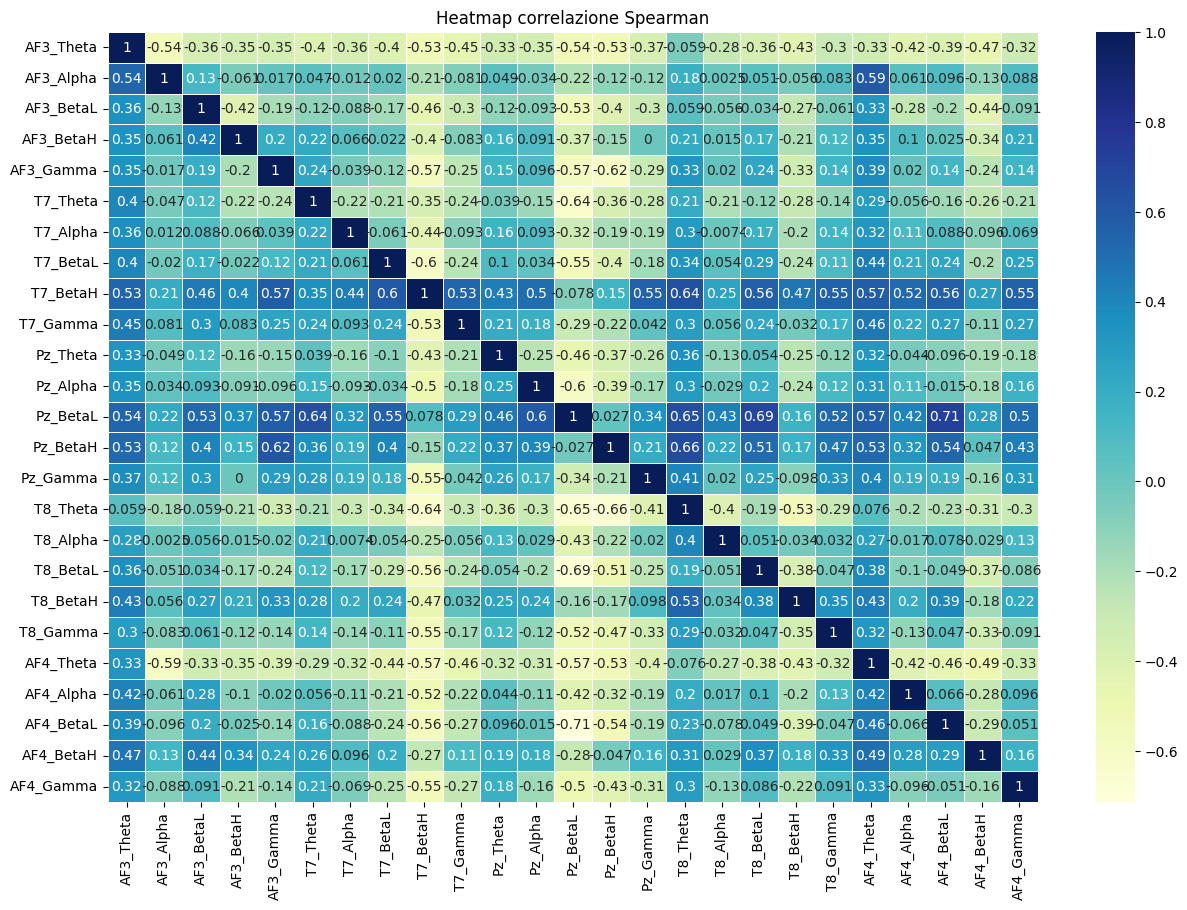

In [42]:
plt.figure(figsize=(15, 10))

sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=columns, yticklabels=columns)

# Aggiungi il titolo
plt.title('Heatmap correlazione Spearman')

# Mostra il plot
plt.show()

---
# ***PEARSON***
---

In [43]:
# Seleziona le colonne di interesse
corr_matrix2 = []
colonna_df1 = new[columns]
for i in colonna_df1.columns:
  rows = []
  for j in colonna_df1.columns:
    if i ==j:
      rows.append(1)
    else:
      df1 = []
      df1.append(colonna_df1[i].values / colonna_df1[j].values)
      colonna_df2 = df_MET['Focus']
      df2 = colonna_df2.values
      # Calcola la correlazione di Spearman tra le due colonne
      correlazione, p_value = pearsonr(df1[0], df2[:-1])
      rows.append(correlazione)
  corr_matrix2.append(rows)

corr_matrix2

[[1,
  -0.5827251962183224,
  -0.3805841684162193,
  -0.39912638467291806,
  -0.31052230819898957,
  -0.1855787658821286,
  -0.24363461197659955,
  -0.3498427124944409,
  -0.4314490609147441,
  -0.377447059322135,
  -0.24380065537471957,
  -0.28186094783972465,
  -0.39626077764492107,
  -0.3754803367429649,
  -0.3412988840489785,
  -0.03927553286034644,
  -0.17284359679228165,
  -0.2697469351403907,
  -0.3565190690711104,
  -0.2568270986708004,
  -0.2628627895267205,
  -0.4251317670120433,
  -0.33067158104924643,
  -0.43425705372724127,
  -0.2599031815791662],
 [0.5309512902828047,
  1,
  0.20251930287238534,
  -0.011976578773808158,
  0.08172512906532586,
  0.15112533808802586,
  0.055330591082799356,
  0.09302860287640374,
  -0.10560298035087186,
  0.020606607599992107,
  0.12534802917610266,
  0.08429668487491107,
  -0.11219267124061183,
  -0.07611313138565544,
  0.015564933929805208,
  0.2802330190786422,
  0.0825967620591263,
  0.17367095193732757,
  0.018709717161690096,
  0.2025

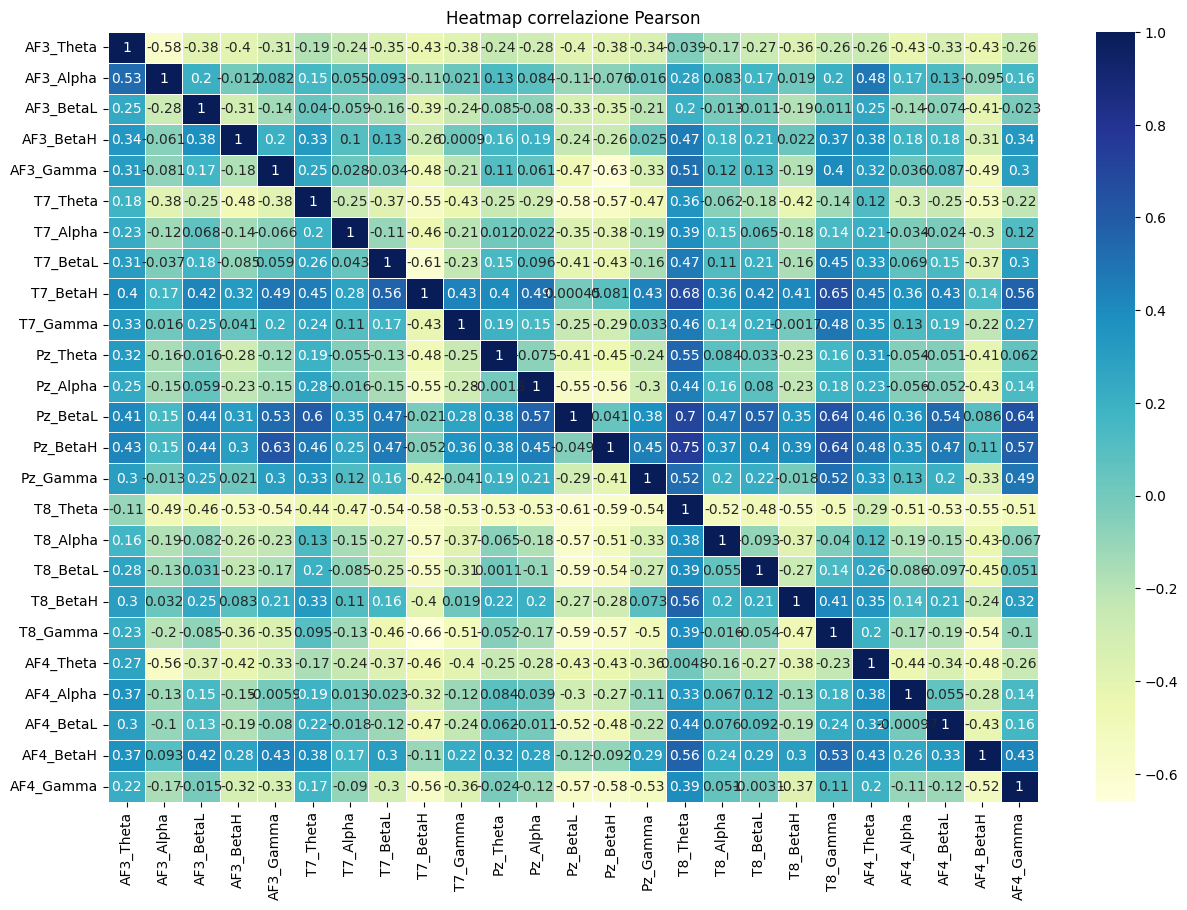

In [45]:
plt.figure(figsize=(15, 10))

sns.heatmap(corr_matrix2, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=columns, yticklabels=columns)

# Aggiungi il titolo
plt.title('Heatmap correlazione Pearson')

# Mostra il plot
plt.show()

---
# ***KENDALLTAU***
---

In [48]:
# Seleziona le colonne di interesse
corr_matrix3 = []
colonna_df1 = new[columns]
for i in colonna_df1.columns:
  rows = []
  for j in colonna_df1.columns:
    if i ==j:
      rows.append(1)
    else:
      df1 = []
      df1.append(colonna_df1[i].values / colonna_df1[j].values)
      colonna_df2 = df_MET['Focus']
      df2 = colonna_df2.values
      # Calcola la correlazione di Spearman tra le due colonne
      correlazione, p_value = kendalltau(df1[0], df2[:-1])
      rows.append(correlazione)
  corr_matrix3.append(rows)

corr_matrix3

[[1,
  -0.45588235294117646,
  -0.2794117647058823,
  -0.24999999999999997,
  -0.2352941176470588,
  -0.30882352941176466,
  -0.24999999999999997,
  -0.24999999999999997,
  -0.3676470588235294,
  -0.2794117647058823,
  -0.2205882352941176,
  -0.2205882352941176,
  -0.3676470588235294,
  -0.3529411764705882,
  -0.2352941176470588,
  -0.014705882352941175,
  -0.20588235294117643,
  -0.2205882352941176,
  -0.2941176470588235,
  -0.19117647058823525,
  -0.2647058823529411,
  -0.2647058823529411,
  -0.2794117647058823,
  -0.30882352941176466,
  -0.2205882352941176],
 [0.45588235294117646,
  1,
  0.08823529411764705,
  -0.02941176470588235,
  0.014705882352941175,
  0.0588235294117647,
  0.0,
  0.02941176470588235,
  -0.14705882352941174,
  -0.044117647058823525,
  0.044117647058823525,
  -0.02941176470588235,
  -0.13235294117647056,
  -0.0588235294117647,
  -0.044117647058823525,
  0.1176470588235294,
  -0.014705882352941175,
  0.0588235294117647,
  -0.044117647058823525,
  0.07352941176470

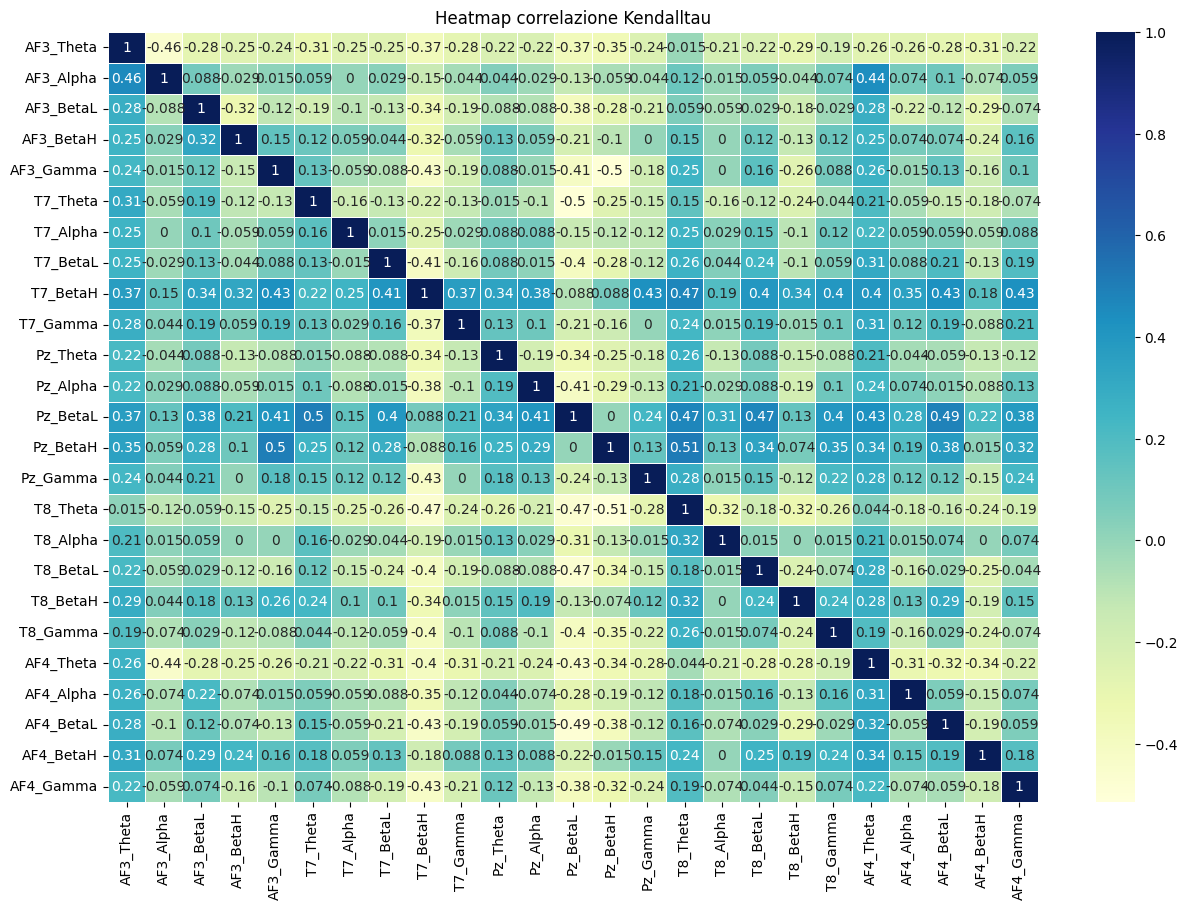

In [49]:
plt.figure(figsize=(15, 10))

sns.heatmap(corr_matrix3, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=columns, yticklabels=columns)

# Aggiungi il titolo
plt.title('Heatmap correlazione Kendalltau')

# Mostra il plot
plt.show()